Data shapes:
X_train: torch.Size([120, 4])
X_test: torch.Size([30, 4])
y_train: torch.Size([120])
y_test: torch.Size([30])
Model architecture:
IrisClassifier(
  (layer): Linear(in_features=4, out_features=3, bias=True)
)

Training:
Epoch 0: Train Loss = 1.7854, Test Loss = 1.6510
          Train Acc = 0.0%, Test Acc = 0.0%
Epoch 50: Train Loss = 0.7208, Test Loss = 0.7042
          Train Acc = 85.0%, Test Acc = 86.7%
Epoch 100: Train Loss = 0.4956, Test Loss = 0.4865
          Train Acc = 91.7%, Test Acc = 90.0%
Epoch 150: Train Loss = 0.4099, Test Loss = 0.4003
          Train Acc = 95.8%, Test Acc = 96.7%
Training completed!

Making predictions on new flowers:
Flower 1: Setosa (89.6% confidence)
Flower 2: Virginica (63.1% confidence)
Flower 3: Versicolor (59.0% confidence)

Final Test accuracy: 100.0%


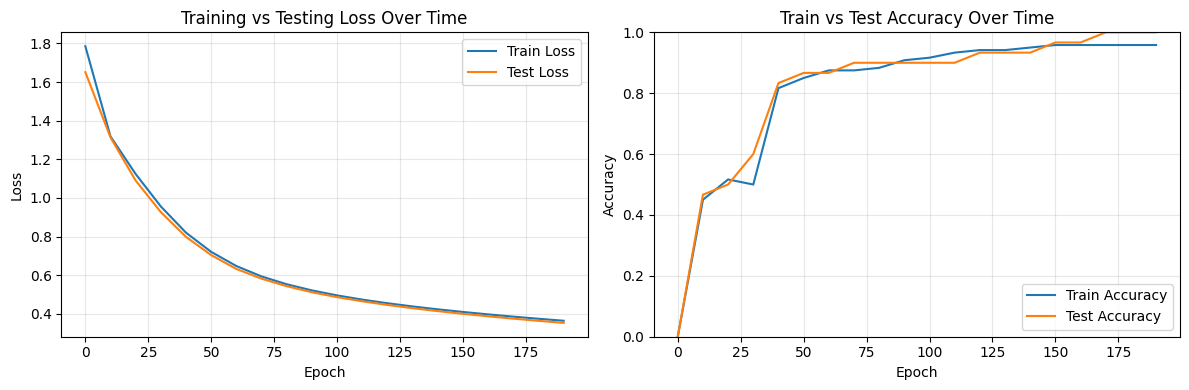

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Step 1a: Load the data from sklearn datasets
iris_data = load_iris()
X = iris_data.data
y = iris_data.target

# Step 1b: Prepare Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

print("Data shapes:")
print("X_train:", X_train.shape)  # [120 samples, 4 features]
print("X_test:", X_test.shape)    # [30 samples, 4 features]
print("y_train:", y_train.shape)  # [120 labels]
print("y_test:", y_test.shape)    # [30 labels]

# Step 2: Create Model
class IrisClassifier(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.layer = nn.Linear(in_dim, 3)  # 4 features → 3 classes

    def forward(self, x):
        return self.layer(x)

model = IrisClassifier(X_train.shape[1])
print("Model architecture:")
print(model)

# Step 3: Define Loss and Optimizer
loss_fn = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Step 4: Train the Model
print("\nTraining:")
train_losses, test_losses = [], []
train_accs, test_accs = [], []
epochs_list = []

for epoch in range(200):
    model.train()
    # Forward pass
    predictions = model(X_train)
    loss = loss_fn(predictions, y_train)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    model.eval()
    with torch.inference_mode():
        test_predictions = model(X_test)
        t_loss = loss_fn(test_predictions, y_test)

        # Calculate accuracies
        train_acc = (predictions.argmax(dim=1) == y_train).float().mean().item()
        test_acc = (test_predictions.argmax(dim=1) == y_test).float().mean().item()

        # Store metrics every 10 epochs
        if epoch % 10 == 0:
            train_losses.append(loss.item())
            test_losses.append(t_loss.item())
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            epochs_list.append(epoch)

            if epoch % 50 == 0:
                print(f"Epoch {epoch}: Train Loss = {loss.item():.4f}, Test Loss = {t_loss.item():.4f}")
                print(f"          Train Acc = {train_acc:.1%}, Test Acc = {test_acc:.1%}")

print("Training completed!")

# Step 5: Make Predictions
print("\nMaking predictions on new flowers:")
new_flowers = torch.tensor([
    [5.0, 3.4, 1.5, 0.2],  # Should be Setosa
    [6.0, 2.7, 5.0, 1.8],  # Should be Virginica
    [5.8, 2.7, 4.2, 1.3],  # Should be Versicolor
], dtype=torch.float32)

# Turn off gradient tracking for prediction
with torch.no_grad():
    # Get model scores
    scores = model(new_flowers)

    # Convert to probabilities
    probabilities = torch.softmax(scores, dim=1)

    # Choose class with highest probability
    predicted_classes = torch.argmax(scores, dim=1)

# Display results
class_names = ['Setosa', 'Versicolor', 'Virginica']
for i in range(len(new_flowers)):
    features = new_flowers[i].numpy()
    pred_class = class_names[predicted_classes[i]]
    confidence = probabilities[i][predicted_classes[i]].item()

    print(f"Flower {i+1}: {pred_class} ({confidence:.1%} confidence)")

# Step 6: Check accuracy on test data
with torch.no_grad():
    test_predictions = model(X_test)
    test_classes = torch.argmax(test_predictions, dim=1)
    correct = (test_classes == y_test).sum().item()
    accuracy = correct / len(y_test) * 100

print(f"\nFinal Test accuracy: {accuracy:.1f}%")

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_list, train_losses, label='Train Loss')
plt.plot(epochs_list, test_losses, label='Test Loss')
plt.title('Training vs Testing Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs_list, train_accs, label='Train Accuracy')
plt.plot(epochs_list, test_accs, label='Test Accuracy')
plt.title('Train vs Test Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()